# Pytorch face detection for ML

*Lionnus Kesting (ETHZ)*

### Import packages

In [1]:
# Start with the basics
import numpy as np
from pandas import DataFrame
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Library for plotting
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.io import read_image

# Import ai8x specifics
#import ai8x

### Set parameters

In [78]:
param_dim_x = 48
param_dim_y = 48

### Set CUDA device

In [3]:
#@title Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


## Define dataset and dataloader classes

In [183]:
###################################################################################################
# WIDER Faces dataloader
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDER Faces dataset
"""
import os
import cv2

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import torch

import ai8x
"""
Custom image dataset class
"""
class WIDERFacesDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.annotation_file = os.path.join(self.data_path, "wider_face_bbx_gt_no_faces.txt")
        self.transform = transform
        
        # Load data and annotations
        self.data, self.annotations = self.load_data()
        
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.data_path, self.annotations[idx]['image'])
        image = self.load_image(image_path)
        
        bboxes = self.annotations[idx]['bboxes']
        face_label = self.annotations[idx]['labels']['faces']

        # Resize image to param_dim_x x param_dim_y and update boundary boxes accordingly
        bboxes_resized = self.resize_bbox(bboxes, image.shape[1], image.shape[0], param_dim_x,param_dim_y)
        image = cv2.resize(image, (param_dim_x,param_dim_y))

        # Convert bboxes and face label to tensors
        bboxes_tensor= torch.tensor([float(i) for i in bboxes_resized[0]])
        
        one_hot_face_label = [0,0]
        one_hot_face_label[0] = float(face_label == 0) # [1,0] for face_label == 1
        one_hot_face_label[1] = float(face_label == 1) # [0,1] for face_label == 0
        one_hot_face_label = torch.tensor([one_hot_face_label])
        #labels = self.annotations[idx]['labels']
        
        if self.transform:
            image = self.transform(image)
        
        return image, bboxes_tensor, one_hot_face_label[0]
    
    def load_data(self):
        annotations = []
        data = []
        
        image_files = os.listdir(self.data_path) # list of all the objects in directory, also includes the folder->check for extension to get images

        with open(self.annotation_file, 'r') as f:
            lines = f.read().splitlines()

        i = 0
        while(i<len(lines)):
                image_name = lines[i]
                image_file_path = os.path.join(self.data_path, image_name)
                i += 1
                num_bboxes = int(lines[i])

                bboxes = []
                labels = []

                # Iterate over the lines containing the boundary box coordinates
                for j in range(num_bboxes):
                    i += 1
                    bbox_data = lines[i].split(' ')
                    bbox = [
                        int(bbox_data[0]),
                        int(bbox_data[1]),
                        int(bbox_data[2]),
                        int(bbox_data[3])
                    ]
                    bboxes.append(bbox)
                # Fix the stupid fact that it has 0 coordinates if it doesnt have a boundary box
                if(num_bboxes==0):
                    bbox_data = [0,0,0,0,0,0,0,0,0,0]
                    bbox=[0,0,0,0]
                    bboxes.append(bbox)
                    i+=1
                label = {
                    'name': image_name.split('/')[1],
                    'faces': num_bboxes,
                    'type': int(image_name.split("--")[0]),
                    'blur': int(bbox_data[4]),
                    'expression': int(bbox_data[5]),
                    'illumination': int(bbox_data[6]),
                    'invalid': int(bbox_data[7]),
                    'occlusion': int(bbox_data[8]),
                    'pose': int(bbox_data[9])
                }
                annotation = {
                    'image': image_name,
                    'bboxes': bboxes,
                    'labels': label
                }
                if(num_bboxes ==1 or num_bboxes == 0):
                    annotations.append(annotation)
                    data.append(image_file_path)
                i += 1

        return data, annotations
    
    def resize_bbox(self,bboxes, dim_x_init,dim_y_init, dim_x,dim_y):
        bboxes_resized = []
        #print(bboxes, dim_x_init,dim_y_init, dim_x,dim_y)
        for bbox in bboxes:
            # Calculate the scaling factors for width and height
            scale_x = dim_x / dim_x_init
            scale_y = dim_y / dim_y_init
            #print(scale_x,scale_y)
            # Convert the coordinates to the new dimensions
            bbox_resized = [ int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
            bboxes_resized.append(bbox_resized)
        #print(bboxes_resized)

        return bboxes_resized
    
    def load_image(self, path):
        # Load and preprocess the image
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image
    
def widerfaces_get_datasets(data, load_train=True, load_test=True):
    """
    Load the WIDER Faces dataset

    The images are of multiple sizes, so they are rescaled to a predefined size.
    """
    (data_dir, args) = data

    if load_train:
        print("Loading training dataset")
        train_transform = transforms.Compose([
            #Rescale(256),
            #RandomCrop(224),
            transforms.ToTensor(),
            transforms.ColorJitter()
            #ai8x.normalize()
        ])

        train_dataset = WIDERFacesDataset(data_path=os.path.join(data_dir, "widerface", "WIDER_train/images"), transform=train_transform)
    else:
        train_dataset = None

    if load_test:
        print("Loading test dataset")
        test_transform = transforms.Compose([
            #Rescale(256),
            #RandomCrop(224),
            transforms.ToTensor(),
            transforms.ColorJitter()
            #ai8x.normalize()
        ])
        # Load validation dataset instead of test dataset, since test dataset is unlabeled
        test_dataset = WIDERFacesDataset(data_path=os.path.join(data_dir, "widerface", "WIDER_val/images"), transform=test_transform)
    else:
        test_dataset = None

    return train_dataset, test_dataset


datasets = [
    {
        'name': 'widerfaces',
        'input': (3, param_dim_x, param_dim_y),
        'output': [('x', float), ('y', float), ('w', float), ('h', float), ('c', float)],
        'regression': True,
        'loader': widerfaces_get_datasets,
    },
]

#### Test dataset class

In [50]:
# Instantiate the dataset
data_path = 'WIDER_faces/train'
#annotation_file = 'wider_face_split/wider_face_train_bbx_gt.txt'
print('before dataset')
#dataset = WIDERFacesDataset(data_path,{1,2,3,4,5,9})
dataset = WIDERFacesDataset(data_path)

# Test a specific sample
sample = dataset[0]
image, bboxes= sample

# Inspect the sample
print("Image shape:", image.shape)
print("Bounding boxes:", bboxes)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Add bounding boxes to the plot
for bbox in [bboxes]:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Random image with Bounding Boxes')

# Show the plot
plt.show()

before dataset


FileNotFoundError: [Errno 2] No such file or directory: 'WIDER_faces/train/wider_face_bbx_gt_no_faces.txt'

## Test dataloader above

#### Define plotting function for boundary boxes

In [125]:
def plotBoundaryBox(image,bbox):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image which is a tensor
    ax.imshow(image.permute(1, 2, 0))

    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.set_title('Image with Boundary box')
    # Show the plot
    plt.show()

In [184]:
args=0
data = ('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection',0)
train_dataset,test_dataset= widerfaces_get_datasets(data,load_train=True)

image, bbox, face_label = train_dataset[6006]

# Inspect the sample
print("Image shape:", image.shape)
print("Bounding boxes:", bbox)
print("Face present?", float(face_label[0][1]))
# Test data loading using DataLoader
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
fixed_size= (param_dim_x,param_dim_y)
plotBoundaryBox(image,bbox)

Loading training dataset
Loading test dataset
Image shape: torch.Size([3, 48, 48])
Bounding boxes: tensor([20.,  7., 12., 11.])


IndexError: index 1 is out of bounds for dimension 0 with size 0

### Easy way

In [80]:
###################################################################################################
#
# Copyright (C) 2019-2021 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################
"""
Classes and functions used to utilize the dataset.
"""
import os

from torchvision import transforms

import ai8x
from torchvision.datasets import WIDERFace


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bboxes = sample[0], sample[1]['bboxes']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transforms.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bboxes = bboxes * [new_w / w, new_h / h]

        return img, bboxes


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bboxes = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        bboxes = bboxes - [left, top]

        return image, bboxes


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bboxes = sample[0], sample[1]['bboxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(bboxes)

def widerfaces_get_datasets(data, load_train=True, load_test=True):
    """
    Load the WIDER Faces dataset

    The images are of multiple sizes, so they are rescaled to a predefined size.
    """
    (data_dir, args) = data

    transform = transforms.Compose([
        #ai8x.normalize(args=args)
    ])

    if load_train:
        print("Loading training dataset")
        train_transform = transforms.Compose([
            #Rescale(256),
            #RandomCrop(224),
            transforms.ToTensor()
            #ai8x.normalize()
        ])

        print('Function arguments to WIDERFace are: {}'.format(data_dir))

        train_dataset = torchvision.datasets.WIDERFace(root=data_dir,split='train', transform=train_transform)
        print('Train dataset is: {}'.format(train_dataset))
        # print data types of each component in train_dataset
        print('Train dataset data types are: {}'.format(train_dataset[0]))
    else:
        train_dataset = None

    if load_test:
        test_transform = transforms.Compose([
            #Rescale(256),
            #RandomCrop(224),
            transforms.ToTensor()
            
            #ai8x.normalize()
        ])
        # Load validation dataset instead of test dataset, since test dataset is unlabeled
        test_dataset = torchvision.datasets.WIDERFace(root=data_dir,split='test', transform=test_transform)
    else:
        test_dataset = None

    return train_dataset, test_dataset


datasets = [
    {
        'name': 'widerfaces',
        'input': (3, param_dim_x, param_dim_y),
        'output': [('x', float), ('y', float), ('w', float), ('h', float)],
        'regression': True,
        'loader': widerfaces_get_datasets,
    },
]

## Define the Networks

### 'Original' WIDERFaceNet

In [8]:
###################################################################################################
# WIDER Faces Network
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt

## Function to calculate linear layer dimensions
def conv_shape(x, k=1, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERFaceNet(nn.Module):
    def __init__(self, num_channels=3, dimensions = (128,128), bias=False, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1, bias=bias)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        dim_x = conv_shape(dimensions[0], k=3, p=1, s=2, d=1)
        print(dim_x) 

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=bias)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        dim_x = conv_shape(dim_x, k=3, p=1, s=2, d=1)
        print(dim_x) 

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=bias)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        dim_x = conv_shape(dim_x, k=3, p=1, s=2, d=1)
        print(dim_x) 

        self.conv4 = nn.Conv2d(16,8, kernel_size=3, padding=1, bias=bias)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        dim_x = conv_shape(dim_x, k=3, p=1, s=2, d=1)
        dim_y=dim_x #change when not square!
        print(dim_x) 

        self.fc1 = nn.Linear(8 *dim_x*dim_y, 32)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(32, 4)

        # Normal distribution as start for the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu5(x)

        x = self.fc2(x)

        return x

def widerfacenet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceNet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'widerfacenet',
        'min_input': 1,
        'dim': 2,
    }
]


### WiderFaceONet

In [180]:
###################################################################################################
# WIDER Faces Network
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt

## Function to calculate linear layer dimensions
def conv_shape(x, k=1, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERFaceONet(nn.Module):
    def __init__(self, num_channels=3, dimensions = (param_dim_x,param_dim_y), bias=False, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride = 1,padding=1, bias=bias)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    
        dim_x = conv_shape(dimensions[0], k=3, p=1, s=1, d=1) # Conv2d
        dim_x = conv_shape(dim_x, k=3, p=0, s=2, d=1) # Maxpool
        # print(dim_x) 

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        dim_x = conv_shape(dim_x, k=3, p=0, s=2, d=1) # Maxpool
        # print(dim_x) 

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        dim_x = conv_shape(dim_x, k=2, p=0, s=1, d=1) # Conv2d
        dim_x = conv_shape(dim_x, k=2, p=0, s=2, d=1) # Maxpool
        # print(dim_x) 

        self.conv4 = nn.Conv2d(64,128, kernel_size=2,stride=1, padding=0, bias=bias)
        self.relu4 = nn.ReLU()

        dim_x = conv_shape(dim_x, k=2, p=0, s=1, d=1) # Conv2d
        dim_x = dim_x#conv_shape(dim_x, k=3, p=1, s=2, d=1)
        dim_y=dim_x #change when not square!
        # print(dim_x) 

        self.fc1 = nn.Linear(128 *dim_x*dim_y, 256)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(256, 2)
        self.out_cls = nn.Softmax(dim=1)

        self.out_bbox = nn.Linear(256, 4)

        # Normal distribution as start for the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # print("Dimensions after first layer: ", x.shape)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # print("Dimensions after second layer: ", x.shape)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        # print("Dimensions after third layer: ", x.shape)
        x = self.conv4(x)
        x = self.relu4(x)
        # print("Dimensions after fourth layer: ", x.shape)
        x = x.view(x.size(0), -1)
        # print(self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu5(x)
        
        out_cls = self.fc2(x)
        out_cls = self.out_cls(out_cls)

        out_bbox = self.out_bbox(x)

        return out_bbox, out_cls

def widerfacenet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceNet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'widerfacenet',
        'min_input': 1,
        'dim': 2,
    }
]


## Train the model

In [181]:
# Define hyperparameters and settings
batch_size = 32
learning_rate = 0.001
num_epochs = 10
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the WIDER Faces dataset
args=0
data = ('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection',0)
train_dataset,test_dataset= widerfaces_get_datasets(data,load_train=True, load_test=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loading training dataset
Loading test dataset


### Training without early stop

In [132]:
# Create an instance of your model
model = WIDERFaceONet().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, bboxes, face_labels in train_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)
        face_labels = face_labels.to(device)

        optimizer.zero_grad()
        
        predicted_coords, predicted_face_label = model(images)
        loss_bbox = criterion(predicted_coords, bboxes)
        loss_face_label = criterion(predicted_face_label, face_labels)

        total_loss_epoch = loss_bbox + loss_face_label
        total_loss_epoch.backward()
        optimizer.step()

        total_loss += total_loss_epoch.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}")

# Evaluation loop
model.eval()
total_loss = 0

with torch.no_grad():
    for images, bboxes in test_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)
        face_labels = face_labels.to(device)

        predicted_coords, predicted_face_label = model(images)
        loss_bbox = criterion(predicted_coords, bboxes)
        loss_face_label = criterion(predicted_face_label, face_labels)

        total_loss_epoch = loss_bbox + loss_face_label

        total_loss += total_loss_epoch.item()

avg_loss = total_loss / len(test_loader)
print(f"Average Test Loss: {avg_loss}")

# Save the trained model 
# torch.save(model.state_dict(), "widerfacenet.pth")


Dimensions after first layer:  torch.Size([32, 32, 23, 23])
Dimensions after second layer:  torch.Size([32, 64, 10, 10])
Dimensions after third layer:  torch.Size([32, 64, 4, 4])
Dimensions after fourth layer:  torch.Size([32, 128, 3, 3])
Dimensions after first layer:  torch.Size([32, 32, 23, 23])
Dimensions after second layer:  torch.Size([32, 64, 10, 10])
Dimensions after third layer:  torch.Size([32, 64, 4, 4])
Dimensions after fourth layer:  torch.Size([32, 128, 3, 3])


/home/lionnus/anaconda3/envs/ai8x-training2/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Dimensions after first layer:  torch.Size([32, 32, 23, 23])
Dimensions after second layer:  torch.Size([32, 64, 10, 10])
Dimensions after third layer:  torch.Size([32, 64, 4, 4])
Dimensions after fourth layer:  torch.Size([32, 128, 3, 3])
Dimensions after first layer:  torch.Size([32, 32, 23, 23])
Dimensions after second layer:  torch.Size([32, 64, 10, 10])
Dimensions after third layer:  torch.Size([32, 64, 4, 4])
Dimensions after fourth layer:  torch.Size([32, 128, 3, 3])
Dimensions after first layer:  torch.Size([32, 32, 23, 23])
Dimensions after second layer:  torch.Size([32, 64, 10, 10])
Dimensions after third layer:  torch.Size([32, 64, 4, 4])
Dimensions after fourth layer:  torch.Size([32, 128, 3, 3])
Dimensions after first layer:  torch.Size([32, 32, 23, 23])
Dimensions after second layer:  torch.Size([32, 64, 10, 10])
Dimensions after third layer:  torch.Size([32, 64, 4, 4])
Dimensions after fourth layer:  torch.Size([32, 128, 3, 3])
Dimensions after first layer:  torch.Size([3

KeyboardInterrupt: 

### Training with early stop

In [226]:
# Define hyperparameters and settings
batch_size = 32
learning_rate = 0.001
num_epochs = 10
# Define early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
counter = 0
# Define device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the WIDER Faces dataset
args=0
data = ('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection',0)
train_dataset,test_val_dataset= widerfaces_get_datasets(data,load_train=True, load_test=True)
test_dataset, val_dataset = torch.utils.data.random_split(test_val_dataset, [int(len(test_val_dataset)*0.5), int(len(test_val_dataset)*0.5)])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create an instance of your model
model = WIDERFaceONet().to(device)

# Define the loss function and optimizer
criterion_bbox = nn.MSELoss()
criterion_face_label = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, bboxes, face_labels in train_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)
        face_labels = face_labels.to(device)

        optimizer.zero_grad()
        predicted_coords, predicted_face_label = model(images)
        # Set requires_grad=True for intermediate tensors
        # predicted_coords.requires_grad = True
        # predicted_face_label.requires_grad = True

        loss_bbox = criterion_bbox(predicted_coords, bboxes)
        loss_face_label = criterion_face_label(predicted_face_label, face_labels)

        total_loss_epoch = loss_bbox + loss_face_label
        total_loss_epoch.backward()
        optimizer.step()

        total_loss += total_loss_epoch.item()

    avg_loss = total_loss / len(train_loader)
    # print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}")

    # Validation loop
    model.eval()
    val_total_loss = 0.0
    with torch.no_grad():
        for images, bboxes, face_labels in val_loader:
            images = images.to(device)
            bboxes = bboxes.to(device)
            face_labels = face_labels.to(device)

            optimizer.zero_grad()
            predicted_coords, predicted_face_label = model(images)
            # Set requires_grad=True for intermediate tensors
            # predicted_coords.requires_grad = True
            # predicted_face_label.requires_grad = True
            
            loss_bbox = criterion_bbox(predicted_coords, bboxes)
            loss_face_label = criterion_face_label(predicted_face_label, face_labels)

            total_loss_epoch = loss_bbox + loss_face_label
            total_loss_epoch.requires_grad = True
            total_loss_epoch.backward()
            optimizer.step()

            val_total_loss += total_loss_epoch.item()

    avg_loss = total_loss / len(train_loader)

    # Print training and validation loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_total_loss / len(val_loader)}")

    # Check for early stopping
    if val_total_loss < best_val_loss:
        best_val_loss = val_total_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

Loading training dataset
Loading test dataset


#### Save the new model

In [186]:
# Get the current directory
current_dir = os.getcwd()

# Specify the subdirectory name for models
models_dir = os.path.join(current_dir, "models")

# Create the models directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Define the base model name
base_model_name = model.__class__.__name__

# Find the latest version number in the models directory
latest_version = 0
for file_name in os.listdir(models_dir):
    if file_name.startswith(base_model_name):
        version_str = file_name[len(base_model_name):].split(".")[0]
        version = int(version_str)
        if version > latest_version:
            latest_version = version

# Increment the latest version number by 1
new_version = latest_version + 1

# Create the new model file path
new_model_path = os.path.join(models_dir, f"{base_model_name}{new_version}.pth")

# Save the model with the new name
torch.save(model.state_dict(), new_model_path)

## Run model on custom sample

(tensor([[ 1.8740, -0.2791,  2.9963,  4.0736]], grad_fn=<AddmmBackward>), tensor([[1.0000e+00, 4.9350e-07]], grad_fn=<SoftmaxBackward>))
BBOX from NN:  [ 1.8740177  -0.27909803  2.9963365   4.0736165 ]
BBOX on original size: x:96.20, y:-19.07, w:153.81, h:278.36


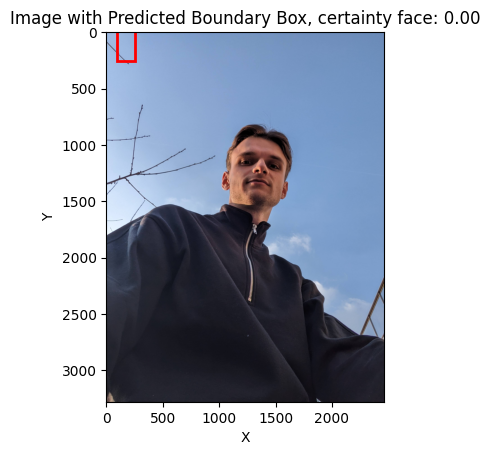

In [225]:
# open the saved pytorch model.pth on cpu
model = WIDERFaceONet()
# model = WIDERFaceNet()
device="cpu"
model.load_state_dict(torch.load("models/WIDERFaceONet1.pth"))
#model_path_ai8x="../Exercise8/ai8x-training/logs/2023.05.23-134755/best.pth.tar"
#model.load_state_dict(torch.load(model_path_ai8x))
model.eval()

# Run the trained PyTorch model on a sample from the test set
# Get a random sample from the test_loader
# images, labels = test_dataset[7]
#import Image library
from PIL import Image, ImageOps
#load image test_pic
image_test = Image.open('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/test_pic1.jpg')
image_test = ImageOps.exif_transpose(image_test)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((param_dim_x,param_dim_y)),  # Resize to match the model's input size
    transforms.ToTensor(),  # Convert image to tensor
])
image_test_trans = transform(image_test).unsqueeze(0)

# Run model on image
print(model(image_test_trans))
predicted_coords, face_label = model(image_test_trans.to(device))
#convert to numpy
predicted_coords = predicted_coords[0].cpu().detach().numpy()
# predicted_coords = predicted_coords
print('BBOX from NN: ',predicted_coords)
#plot the image_test with the predicted coordinates

# Create a figure and plot the image
fig, ax = plt.subplots()
plt.imshow(image_test)

# Plot the predicted coordinates on the image
x, y, w, h = predicted_coords
# Convert coordinates to image dimensions
x = x * image_test.size[0]/param_dim_x
y = y * image_test.size[1]/param_dim_y
w = w * image_test.size[0]/param_dim_x
h = h * image_test.size[1]/param_dim_y
print('BBOX on original size: x:{:.2f}, y:{:.2f}, w:{:.2f}, h:{:.2f}'.format(x, y, w, h))

rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# Set plot title and labels
ax.set_title('Image with Predicted Boundary Box, certainty face: {:.2f}'.format(face_label.detach().numpy()[0][1]))
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

#### Check size of some big models

In [84]:
# Import facenet-pytorch and other modules
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import torch.nn as nn

# Create a MTCNN model for face detection
mtcnn = MTCNN(image_size=128, margin=0).eval()
print(mtcnn)
resnet = InceptionResnetV1(pretrained=None).eval()
print(resnet)


MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

#### Implement RCNN

In [50]:
###################################################################################################
# WIDER Faces Network RCNN Inspired
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt
## Function to calculate linear layer dimensions
def conv_shape(x, k=1, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERRCNN(nn.Module):
    def __init__(self, num_classes=2, dimensions=(128,128), bias=False, **kwargs):
        super().__init__()
        
        # Feature extractor (backbone)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Region proposal network (RPN)
        self.rpn_conv = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.rpn_cls = nn.Conv2d(256, 2, kernel_size=1, stride=1)
        self.rpn_bbox = nn.Conv2d(256, 4, kernel_size=1, stride=1)
        
        # Region of interest (RoI) pooling
        self.roi_pool = nn.AdaptiveMaxPool2d((7, 7))
        
        # Fully connected layers for classification and bounding box regression
        self.fc1 = nn.Linear(7 * 7 * 128, 512)
        self.fc_cls = nn.Linear(512, num_classes)
        self.fc_bbox = nn.Linear(512, 4)
        
        # Activation functions
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Extract features
        features = self.features(x)
        
        # Region proposal network (RPN)
        rpn_conv = self.relu(self.rpn_conv(features))
        rpn_cls = self.softmax(self.rpn_cls(rpn_conv))
        rpn_bbox = self.rpn_bbox(rpn_conv)
        
        # Region of interest (RoI) pooling
        roi_pool = self.roi_pool(features)
        roi_pool_flat = torch.flatten(roi_pool, start_dim=1)
        
        # Fully connected layers for classification and bounding box regression
        fc1 = self.relu(self.fc1(roi_pool_flat))
        fc_cls = self.softmax(self.fc_cls(fc1))
        fc_bbox = self.fc_bbox(fc1)
        
        return fc_bbox, fc_cls#rpn_bbox, rpn_cls, fc_cls, fc_bbox

### Make samples without faces

In [47]:
import cv2
import numpy as np
import os
import random

MAX_ATTEMPTS = 10

def load_data(data_path):
    annotation_file = os.path.join(data_path, "wider_face_bbx_gt.txt")
    annotations = []
    image_paths = []
    
    with open(annotation_file, 'r') as f:
        lines = f.read().splitlines()

    i = 0
    while(i<len(lines)):
            image_name = lines[i]
            image_file_path = os.path.join(data_path, image_name)
            i += 1
            num_bboxes = int(lines[i])

            bboxes = []
            labels = []

            # Iterate over the lines containing the boundary box coordinates
            for j in range(num_bboxes):
                i += 1
                bbox_data = lines[i].split(' ')
                bbox = [
                    int(bbox_data[0]),
                    int(bbox_data[1]),
                    int(bbox_data[2]),
                    int(bbox_data[3])
                ]
                bboxes.append(bbox)
            # Fix the stupid fact that it has 0 coordinates if it doesnt have a boundary box
            if(num_bboxes==0):
                bbox_data = [0,0,0,0,0,0,0,0,0,0]
                bbox=[0,0,0,0]
                bboxes.append(bbox)
                i+=1
            label = {
                'name': image_name.split('/')[1],
                'faces': num_bboxes,
                'type': int(image_name.split("--")[0]),
                'blur': int(bbox_data[4]),
                'expression': int(bbox_data[5]),
                'illumination': int(bbox_data[6]),
                'invalid': int(bbox_data[7]),
                'occlusion': int(bbox_data[8]),
                'pose': int(bbox_data[9])
            }
            annotation = {
                'image': image_name,
                'bboxes': bboxes,
                'labels': label
            }
            annotations.append(annotation)
            image_paths.append(image_file_path)
            i += 1

    return image_paths, annotations

def check_overlap(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    
    # Calculate the coordinates of the rectangles' edges
    left1 = x1
    right1 = x1 + w1
    top1 = y1
    bottom1 = y1 - h1
    
    left2 = x2
    right2 = x2 + w2
    top2 = y2
    bottom2 = y2 - h2
    
    # # Check for overlap along both axes
    if top2<bottom1 or bottom2>top1 or right2<left1 or left2>right1:
        return False
  
    # If overlap occurs along both axes, rectangles overlap
    return True

def calculate_iou(box1, box2):
    # Extract box coordinates
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate box areas
    area1 = w1 * h1
    area2 = w2 * h2
    
    # Calculate intersection coordinates
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Calculate intersection area
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)
    
    # Calculate union area
    union_area = area1 + area2 - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou

def crop_images_with_no_bounding_boxes(data_path, output_path, crop_size=(128, 128)):
    image_paths, annotations = load_data(data_path)
    
    # Iterate over the image files
    for annotation in annotations:
        # Read the image
        image_path = os.path.join(data_path, annotation['image'])
        print(image_path)
        print(annotation['image'])
        print(annotation['bboxes'])
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        # Generate random crops until a crop is found with no bounding boxes or reach the maximum attempts
        for _ in range(MAX_ATTEMPTS):
            # Randomly select the top-left coordinates of the crop
            x = random.randint(0, width - crop_size[0])
            y = random.randint(0, height - crop_size[1])
            crop = (x, y, crop_size[0], crop_size[1])
            # Check if crop is out of bounds
            if x + crop_size[0] > width or y - crop_size[1] < 0:
                continue

            # Check if the crop overlaps with any bounding box
            overlap = False
            for bbox in annotation['bboxes']:
                if calculate_iou(crop, bbox)>0:
                    overlap = True
                    print("Found overlap with bounding box")
                    break

            # If no overlap, save the cropped image and exit the loop
            if not overlap:
                cropped_image = image[y:y+crop_size[1], x:x+crop_size[0]]
                # Make output directory if it doesnt exist
                if not os.path.exists(output_path):
                    os.makedirs(output_path)

                save_path = os.path.join(output_path, f"no_face_{len(os.listdir(output_path)) + 1}.jpg")
                print(f"Saving cropped image {image_path} as {save_path}")
                cv2.imwrite(save_path, cropped_image)
                break


# Example usage
input_path = '/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images'
output_path = '/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/62--No_faces'

crop_images_with_no_bounding_boxes(input_path, output_path, (128,128))

/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/0--Parade/0_Parade_marchingband_1_465.jpg
0--Parade/0_Parade_marchingband_1_465.jpg
[[345, 211, 4, 4], [331, 126, 3, 3], [250, 126, 3, 4], [221, 128, 4, 5], [427, 116, 3, 4], [393, 79, 3, 4], [373, 119, 3, 4], [90, 225, 6, 5], [128, 237, 5, 8], [170, 230, 5, 6], [114, 285, 5, 7], [81, 304, 9, 9], [44, 303, 10, 8], [7, 264, 6, 8], [31, 231, 5, 6], [26, 192, 6, 8], [66, 196, 4, 6], [74, 175, 5, 5], [113, 168, 4, 5], [129, 165, 4, 5], [158, 162, 4, 4], [174, 156, 5, 6], [197, 159, 4, 4], [192, 191, 3, 5], [242, 179, 5, 6], [161, 269, 5, 6], [0, 317, 3, 8], [346, 68, 3, 4], [418, 62, 2, 3], [376, 59, 3, 3], [120, 599, 12, 17], [1008, 256, 6, 10], [853, 131, 4, 5], [878, 131, 5, 5], [900, 138, 4, 6], [922, 142, 5, 5], [936, 139, 5, 6], [959, 134, 5, 7], [984, 141, 5, 5], [1010, 141, 4, 6], [877, 168, 7, 9], [947, 160, 5, 7], [963, 190, 5, 7], [982, 194, 5, 7], [798, 133, 4, 4], [815, 170, 4, 5], [794, 

KeyboardInterrupt: 

### Generate updated annotation file

In [48]:
import os

def generate_empty_annotation_file(folder_path, output_file):
    with open(output_file, 'w') as f:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".jpg"):
                    image_path = os.path.join(root, file)
                    path_name = image_path.split("/images/")[1]
                    f.write(f"{path_name}\n")
                    f.write("0\n")
                    f.write("0 0 0 0 0 0 0 0 0 0\n")

# Example usage
folder_path = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/62--No_faces"
output_file = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/62--No_faces/No_faces_annotation.txt"

generate_empty_annotation_file(folder_path, output_file)

# Append the generated file to the widerface train annotation file, and save under new name wider_face_bbx_gt_no_faces.txt
# Read the content of the source file
source_file = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/wider_face_bbx_gt.txt"
new_file = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/wider_face_bbx_gt_no_faces.txt"
with open(source_file, 'r') as f:
    source_content = f.read()

# Read the content of the target file
with open(output_file, 'r') as f:
    target_content = f.read()

# Append the source content to the target content
combined_content = target_content + source_content

# Save the combined content to a new file
with open(new_file, 'w') as f:
    f.write(combined_content)

